In [3]:
import h5py
import keras
import numpy as np
import os
import random
import sys
import tensorflow as tf

sys.path.append("../src")
import localmodule


# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_input_hops = 104
n_filters = [24, 48, 48]
kernel_size = [5, 5]
pool_size = [2, 4]
n_hidden_units = 64


# Define and compile Keras model.
# NB: the original implementation of Justin Salamon in ICASSP 2017 relies on
# glorot_uniform initialization for all layers, and the optimizer is a
# stochastic gradient descent (SGD) with a fixed learning rate of 0.1.
# Instead, we use a he_uniform initialization for the layers followed
# by rectified linear units (see He ICCV 2015), and replace the SGD by
# the Adam adaptive stochastic optimizer (see Kingma ICLR 2014).
model = keras.models.Sequential()

# Layer 1
bn = keras.layers.normalization.BatchNormalization(
    input_shape=(128, n_input_hops, 1))
model.add(bn)
conv1 = keras.layers.Convolution2D(n_filters[0], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")
model.add(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=pool_size)
model.add(pool1)

# Layer 2
conv2 = keras.layers.Convolution2D(n_filters[1], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")
model.add(conv2)
pool2 = keras.layers.MaxPooling2D(pool_size=pool_size)
model.add(pool2)

# Layer 3
conv3 = keras.layers.Convolution2D(n_filters[2], kernel_size,
    padding="same", kernel_initializer="he_normal", activation="relu")
model.add(conv3)

# Layer 4
drop1 = keras.layers.Dropout(0.5)
model.add(drop1)
flatten = keras.layers.Flatten()
model.add(flatten)
dense1 = keras.layers.Dense(n_hidden_units,
    kernel_initializer="he_normal", activation="relu",
    kernel_regularizer=keras.regularizers.l2(0.01))
model.add(dense1)

# Layer 5
# We put a single output instead of 43 in the original paper, because this
# is binary classification instead of multilabel classification.
drop2 = keras.layers.Dropout(0.5)
model.add(drop2)
dense2 = keras.layers.Dense(1,
    kernel_initializer="normal", activation="sigmoid",
    kernel_regularizer=keras.regularizers.l2(0.0002))
model.add(dense2)


# Compile model, print model summary.
metrics = ["accuracy"]
#model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=metrics)
#model.compile(loss="mse", optimizer="adam", metrics=metrics)
model.compile(loss="mse", optimizer="sgd", metrics=metrics)
#model.summary()


# Train model.
fold_units = ["unit01"]
augs = ["original"]
aug_dict = localmodule.get_augmentations()
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
logmelspec_name = "_".join([dataset_name, "logmelspec"])
logmelspec_dir = os.path.join(data_dir, logmelspec_name)
original_dir = os.path.join(logmelspec_dir, "original")
n_hops = 104

Xs = []
ys = []
for unit_str in units[:2]:
    unit_name = "_".join([dataset_name, "original", unit_str])
    unit_path = os.path.join(original_dir, unit_name + ".hdf5")
    lms_container = h5py.File(unit_path)
    lms_group = lms_container["logmelspec"]
    keys = list(lms_group.keys())

    for key in keys:
        X = lms_group[key]
        X_width = X.shape[1]
        first_col = int((X_width-n_hops) / 2)
        last_col = int((X_width+n_hops) / 2)
        X = X[:, first_col:last_col]
        X = np.array(X)[np.newaxis, :, :, np.newaxis]
        Xs.append(X)
        ys.append(np.float32(key.split("_")[3]))
    X = np.concatenate(Xs, axis=0)
    y = np.array(ys)

In [4]:
X.shape

(15312, 128, 104, 1)

In [2]:
# MSE, ADAM
model.fit(X[:,:,:,:], y[:], epochs=1, verbose=True)
print(model.evaluate(X, y))

Epoch 1/1
5852/5852 [==============================] - 72s     

In [ ]:
# MSE, SGD
model.fit(X[:,:,:,:], y[:], epochs=1, verbose=True)
print(model.evaluate(X, y))

Epoch 1/1
 7264/15312 [=============>................] - ETA: 100s

In [2]:
# MSE, SGD
model.fit(X[:,:,:,:], y[:], epochs=1, verbose=True)
print(model.evaluate(X, y))

Epoch 1/1
5852/5852 [==============================] - 72s     

In [2]:
# BCE, SGD
model.fit(X[:,:,:,:], y[:], epochs=1, verbose=True)
print(model.evaluate(X, y))

Epoch 1/1
5852/5852 [==============================] - 72s     

In [2]:
# BCE, ADAM
model.fit(X[:,:,:,:], y[:], epochs=1, verbose=True)
print(model.evaluate(X, y))

Epoch 1/1
5852/5852 [==============================] - 72s     

In [129]:
m = keras.models.Sequential()
m.add(keras.layers.Dense(1, input_shape=(1,)))
X = np.array([[0.0], [1.0]])
y = np.array([0.0, 1.0])
m.compile(optimizer="sgd", loss="binary_crossentropy")
print(m.layers[0].get_weights())
m.fit(X, y, epochs=500, verbose=False)
print(m.predict(X))
print(m.layers[0].get_weights())

[array([[-0.25976813]], dtype=float32), array([ 0.], dtype=float32)]
[[ 0.        ]
 [-0.25976813]]
[array([[-0.25976813]], dtype=float32), array([ 0.], dtype=float32)]


In [134]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Generate dummy data
neg_X = np.random.randn(500, 2) + np.array([-2.0, 1.0])
pos_X = np.random.randn(500, 2) + np.array([1.0, -2.0])
X = np.concatenate((neg_X, pos_X), axis=0)
neg_Y = np.zeros((500,))
pos_Y = np.ones((500,))
Y = np.concatenate((neg_Y, pos_Y), axis=0)

model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.layers[0].get_weights())
model.fit(X, Y, epochs=20, batch_size=100, verbose=False)
print(model.layers[0].get_weights())

[array([[-0.11947656,  0.61539656,  0.35237628, -0.42045242, -0.10635978,
        -0.70158517, -0.39677969, -0.5584265 , -0.31452945, -0.64936763],
       [-0.31949806, -0.60264212, -0.04683053,  0.12245125, -0.41256908,
        -0.11353838, -0.41940328, -0.68450022, -0.0062207 , -0.06409407]], dtype=float32), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)]
[array([[-0.21787041,  0.59552658,  0.28620219, -0.59701407, -0.26289412,
        -0.8668977 , -0.57356513, -0.64596599, -0.13628362, -0.47922936],
       [-0.21896617, -0.63976008,  0.02422422,  0.29651019, -0.24379101,
         0.06879032, -0.23495869, -0.5479548 , -0.19217376, -0.21270375]], dtype=float32), array([-0.02156365,  0.04450258, -0.07965007,  0.16395904, -0.15797964,
        0.05222137, -0.1010966 , -0.0896877 , -0.0907311 , -0.16821335], dtype=float32)]


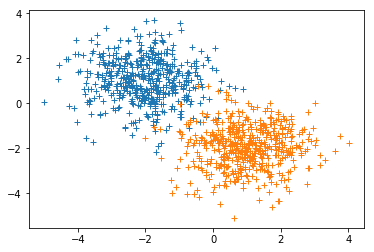

In [135]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(neg_X[:, 0], neg_X[:, 1], '+');
plt.plot(pos_X[:, 0], pos_X[:, 1], '+');

(500, 2)